# Strain mapping with all calibrations
___

## 4C: Measure lattice strain - Visualize

Plot strain maps.

___

- Inputs:
  - strain maps
- Outputs:
  - pretty pretty pictures

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import medfilt

from py4DSTEM.process.calibration import RQ_axes
from py4DSTEM.file.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray
from py4DSTEM.file.io import FileBrowser, read, append

In [3]:
# Examine contents of processing_sampledata.h5

fp_processing = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/processing_sampledata.h5"
browser = py4DSTEM.file.io.FileBrowser(fp_processing)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_calibrationdata_shiftcorrectedDiffractionSlice    
   1    braggvectormap_corrected_calibrationdataDiffractionSlice    
   2    braggvectormap_corrected_experiment DiffractionSlice    
   3    braggvectormap_experiment_shiftcorrectedDiffractionSlice    
   4    braggvectormap_uncorrected_calibrationdataDiffractionSlice    
   5    braggvectormap_uncorrected_experimentDiffractionSlice    
   6    probe                               DiffractionSlice    
   7    diffractionshifts_calibrationdata   RealSlice           
   8    diffractionshifts_experiment        RealSlice           
   9    lattice_parameter_maps_Angs         RealSlice           
   10   strainmap_oriented                  RealSlice           
   11   strainmap_unoriented                RealSlice           
   12   virtual_image                       RealSlice           
   13   Qpixel_calibration                  PointList           
 

In [4]:
# Load data

strain_map = browser.get_dataobject('strainmap_unoriented')
RQ_offset_angle = browser.get_dataobject('RQ_rotational_offset_degrees').data[0][0]
reference_lattice = browser.get_dataobject('reference_lattice')
lattice_parameter_maps = browser.get_dataobject('lattice_parameter_maps_Angs')
browser.close()

ux_ref,uy_ref = reference_lattice.data['ux'][0],reference_lattice.data['uy'][0]

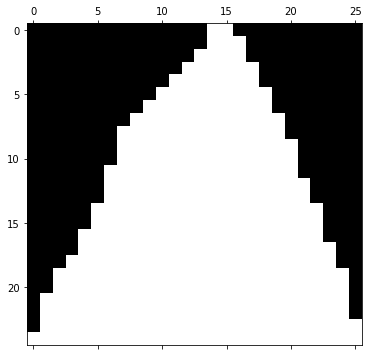

In [5]:
# Get mask

mask = strain_map.slices['mask'].astype(bool)

fig,ax = plt.subplots(figsize=(6,6))
ax.matshow(mask)
plt.show()

In [6]:
# Get real spaec direction of exx/eyy axes

axes = RQ_axes(RQ_offset_angle)
axes.set_Q_axes(ux_ref,uy_ref)

### Square layout

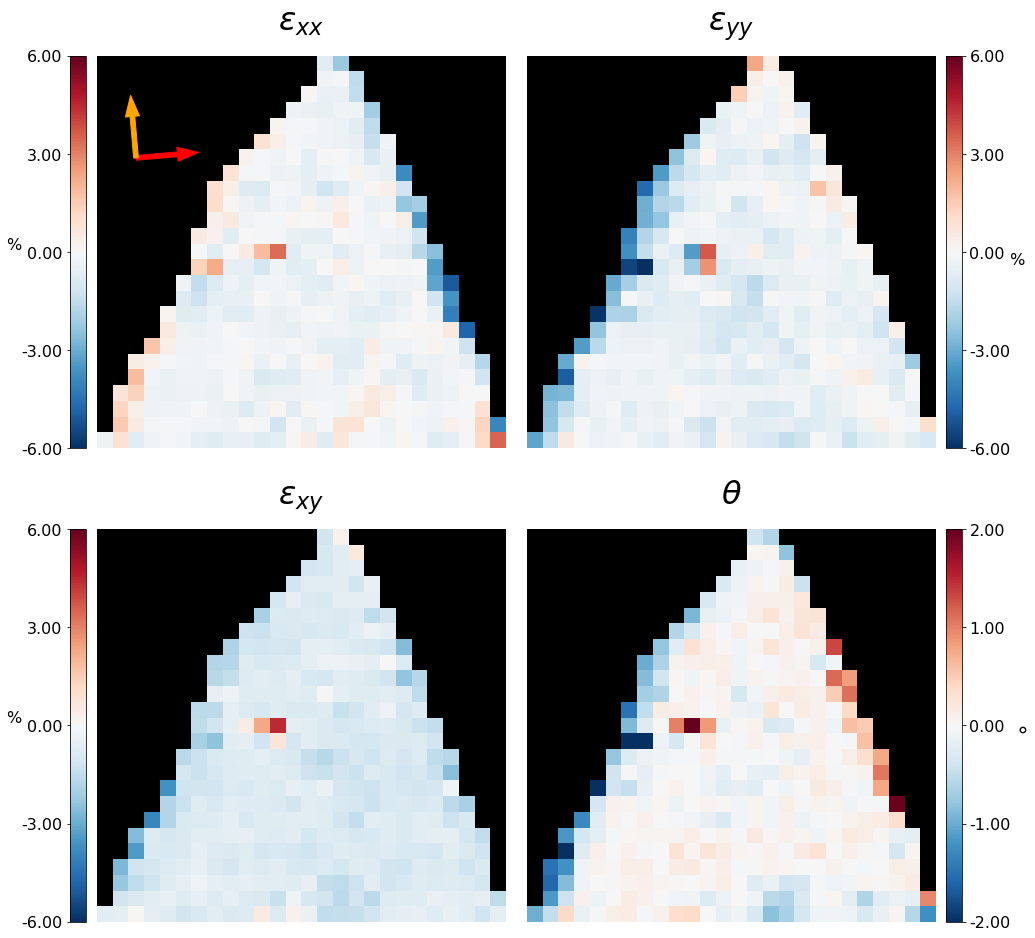

In [7]:
# Plot data
# Unfiltered
# Sqaure layout

############ Params ############

titlesize=32
ticklabelsize=16

# Set colorscales
automate_colorscale = False
n_stds=3

e_xx_range = [-6,6] # In percentage
e_yy_range = [-6,6] # In percentage
e_xy_range = [-6,6] # In percentage
theta_range = [-2,2] # In degrees

show_axes = True
axes_plot = 'e_xx'       # must be 'e_xx', 'e_yy', 'e_xy', or 'theta'
axes_x,axes_y = 6,2
axes_length = 4
axes_width = 0.3

#################################

# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_ave, e_xx_std = np.average(strain_map.slices['e_xx'][mask]),np.std(strain_map.slices['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_map.slices['e_yy'][mask]),np.std(strain_map.slices['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_map.slices['e_xy'][mask]),np.std(strain_map.slices['e_xy'][mask])
theta_ave, theta_std = np.average(strain_map.slices['theta'][mask]),np.std(strain_map.slices['theta'][mask])

if automate_colorscale:
    e_xx_range = [-n_stds*e_xx_std*100,n_stds*e_xx_std*100]
    e_yy_range = [-n_stds*e_yy_std*100,n_stds*e_yy_std*100]
    e_xy_range = [-n_stds*e_xy_std*100,n_stds*e_xy_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]

### Plot ###
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,
                                             figsize=(16,17),
                                             gridspec_kw={'wspace':0.05,'hspace':0.05})

cax11 = ax11.matshow(strain_map.slices['e_xx'],vmin=e_xx_range[0]/100., vmax=e_xx_range[1]/100., cmap="RdBu_r")
cax12 = ax12.matshow(strain_map.slices['e_yy'],vmin=e_yy_range[0]/100., vmax=e_yy_range[1]/100., cmap="RdBu_r")
cax21 = ax21.matshow(strain_map.slices['e_xy'],vmin=e_xy_range[0]/100., vmax=e_xy_range[1]/100., cmap="RdBu_r")
cax22 = ax22.matshow(strain_map.slices['theta'],vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax11.matshow(plot_mask,cmap='gray')
ax12.matshow(plot_mask,cmap='gray')
ax21.matshow(plot_mask,cmap='gray')
ax22.matshow(plot_mask,cmap='gray')

# Colorbars
divider11 = make_axes_locatable(ax11)
divider12 = make_axes_locatable(ax12)
divider21 = make_axes_locatable(ax21)
divider22 = make_axes_locatable(ax22)
cbax11 = divider11.append_axes("left", size="4%", pad=0.15)
cbax12 = divider12.append_axes("right", size="4%", pad=0.15)
cbax21 = divider21.append_axes("left", size="4%", pad=0.15)
cbax22 = divider22.append_axes("right", size="4%", pad=0.15)

cb11 = plt.colorbar(cax11, cax=cbax11, ticks=np.linspace(e_xx_range[0]/100.,e_xx_range[1]/100.,5,endpoint=True))
cb12 = plt.colorbar(cax12, cax=cbax12, ticks=np.linspace(e_yy_range[0]/100.,e_yy_range[1]/100.,5,endpoint=True))
cb21 = plt.colorbar(cax21, cax=cbax21, ticks=np.linspace(e_xy_range[0]/100.,e_xy_range[1]/100.,5,endpoint=True))
cb22 = plt.colorbar(cax22, cax=cbax22, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True))

cb11.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xx_range[0],e_xx_range[1],5,endpoint=True)],size=ticklabelsize)
cb12.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_yy_range[0],e_yy_range[1],5,endpoint=True)],size=ticklabelsize)
cb21.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xy_range[0],e_xy_range[1],5,endpoint=True)],size=ticklabelsize)
cb22.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax11.yaxis.set_ticks_position('left')
cbax21.yaxis.set_ticks_position('left')

cbax11.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax12.set_ylabel(" %", size=ticklabelsize, rotation=0)
cbax21.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax22.set_ylabel(r" $^\circ$", size=2*ticklabelsize, rotation=0)

cbax11.yaxis.set_label_position('left')
cbax12.yaxis.set_label_position('right')
cbax21.yaxis.set_label_position('left')
cbax22.yaxis.set_label_position('right')

ax11.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax12.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax21.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax22.set_title(r'$\theta$',size=titlesize)

if show_axes:
    ax = {'e_xx':ax11,'e_yy':ax12,'e_xy':ax21,'theta':ax22}[axes_plot]
    ax.arrow(axes_y,axes_x,axes_length*axes.Ruy,axes_length*axes.Rux, color='red',width=axes_width,length_includes_head=True)
    ax.arrow(axes_y,axes_x,axes_length*axes.Rvy,axes_length*axes.Rvx, color='orange',width=axes_width,length_includes_head=True)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')

plt.show()

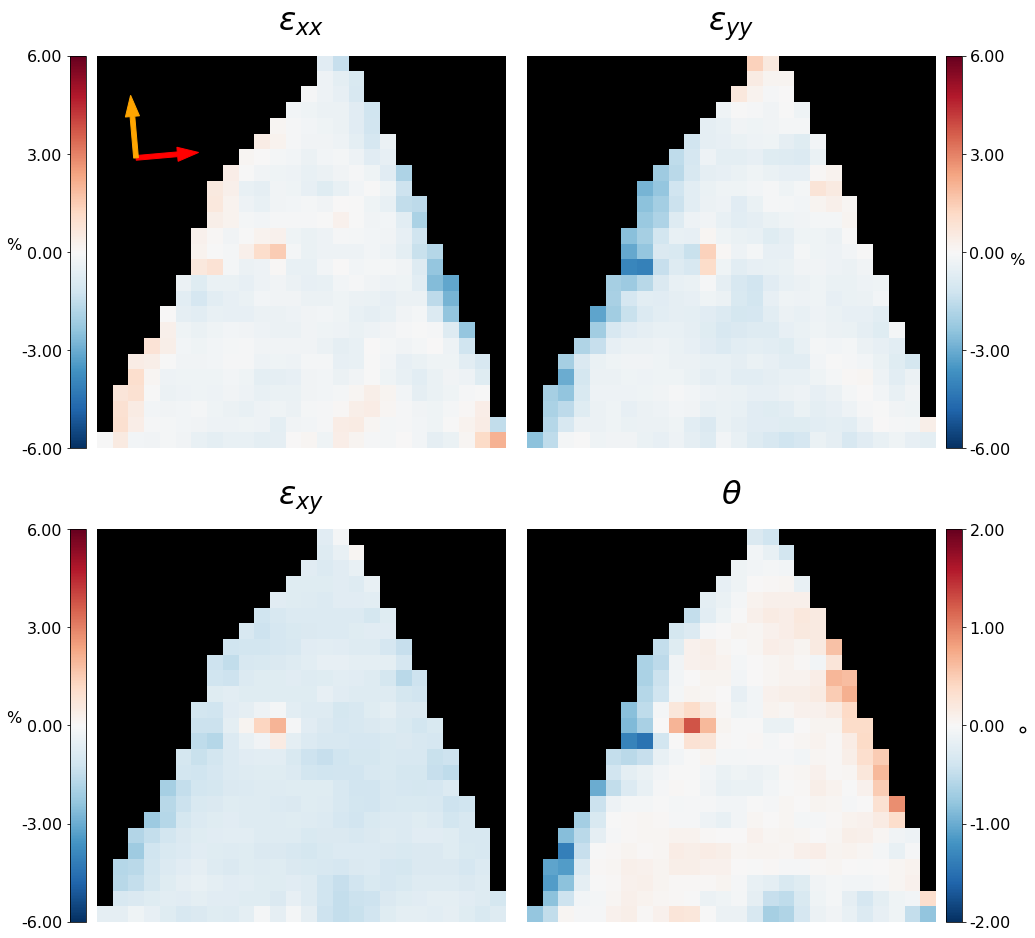

In [8]:
# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

############ Params ############

sigma = .6
titlesize=32
ticklabelsize=16

# Set colorscales
automate_colorscale = False
n_stds=3

e_xx_range = [-6,6] # In percentage
e_yy_range = [-6,6] # In percentage
e_xy_range = [-6,6] # In percentage
theta_range = [-2,2] # In degrees

show_axes = True
axes_plot = 'e_xx'       # must be 'e_xx', 'e_yy', 'e_xy', or 'theta'
axes_x,axes_y = 6,2
axes_length = 4
axes_width = 0.3

#################################

# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.slices['e_xx'], medfilt(np.where(mask,strain_map.slices['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.slices['e_yy'], medfilt(np.where(mask,strain_map.slices['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.slices['e_xy'], medfilt(np.where(mask,strain_map.slices['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_map.slices['theta'], medfilt(np.where(mask,strain_map.slices['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave, e_xx_std = np.average(e_xx_smoothed[mask]),np.std(e_xx_smoothed[mask])
e_yy_ave, e_yy_std = np.average(e_yy_smoothed[mask]),np.std(e_yy_smoothed[mask])
e_xy_ave, e_xy_std = np.average(e_xy_smoothed[mask]),np.std(e_xy_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

if automate_colorscale:
    e_xx_range = [-n_stds*e_xx_std*100,n_stds*e_xx_std*100]
    e_yy_range = [-n_stds*e_yy_std*100,n_stds*e_yy_std*100]
    e_xy_range = [-n_stds*e_xy_std*100,n_stds*e_xy_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]

### Plot ###
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,
                                             figsize=(16,17),
                                             gridspec_kw={'wspace':0.05,'hspace':0.05})

cax11 = ax11.matshow(e_xx_smoothed,vmin=e_xx_range[0]/100., vmax=e_xx_range[1]/100., cmap="RdBu_r")
cax12 = ax12.matshow(e_yy_smoothed,vmin=e_yy_range[0]/100., vmax=e_yy_range[1]/100., cmap="RdBu_r")
cax21 = ax21.matshow(e_xy_smoothed,vmin=e_xy_range[0]/100., vmax=e_xy_range[1]/100., cmap="RdBu_r")
cax22 = ax22.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax11.matshow(plot_mask,cmap='gray')
ax12.matshow(plot_mask,cmap='gray')
ax21.matshow(plot_mask,cmap='gray')
ax22.matshow(plot_mask,cmap='gray')

# Colorbars
divider11 = make_axes_locatable(ax11)
divider12 = make_axes_locatable(ax12)
divider21 = make_axes_locatable(ax21)
divider22 = make_axes_locatable(ax22)
cbax11 = divider11.append_axes("left", size="4%", pad=0.15)
cbax12 = divider12.append_axes("right", size="4%", pad=0.15)
cbax21 = divider21.append_axes("left", size="4%", pad=0.15)
cbax22 = divider22.append_axes("right", size="4%", pad=0.15)

cb11 = plt.colorbar(cax11, cax=cbax11, ticks=np.linspace(e_xx_range[0]/100.,e_xx_range[1]/100.,5,endpoint=True))
cb12 = plt.colorbar(cax12, cax=cbax12, ticks=np.linspace(e_yy_range[0]/100.,e_yy_range[1]/100.,5,endpoint=True))
cb21 = plt.colorbar(cax21, cax=cbax21, ticks=np.linspace(e_xy_range[0]/100.,e_xy_range[1]/100.,5,endpoint=True))
cb22 = plt.colorbar(cax22, cax=cbax22, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True))

cb11.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xx_range[0],e_xx_range[1],5,endpoint=True)],size=ticklabelsize)
cb12.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_yy_range[0],e_yy_range[1],5,endpoint=True)],size=ticklabelsize)
cb21.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xy_range[0],e_xy_range[1],5,endpoint=True)],size=ticklabelsize)
cb22.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax11.yaxis.set_ticks_position('left')
cbax21.yaxis.set_ticks_position('left')

cbax11.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax12.set_ylabel(" %", size=ticklabelsize, rotation=0)
cbax21.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax22.set_ylabel(r" $^\circ$", size=2*ticklabelsize, rotation=0)

cbax11.yaxis.set_label_position('left')
cbax12.yaxis.set_label_position('right')
cbax21.yaxis.set_label_position('left')
cbax22.yaxis.set_label_position('right')

ax11.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax12.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax21.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax22.set_title(r'$\theta$',size=titlesize)

if show_axes:
    ax = {'e_xx':ax11,'e_yy':ax12,'e_xy':ax21,'theta':ax22}[axes_plot]
    ax.arrow(axes_y,axes_x,axes_length*axes.Ruy,axes_length*axes.Rux, color='red',width=axes_width,length_includes_head=True)
    ax.arrow(axes_y,axes_x,axes_length*axes.Rvy,axes_length*axes.Rvx, color='orange',width=axes_width,length_includes_head=True)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')

plt.show()